In [ ]:
import torch
import pandas as pd
from transformers import BertTokenizer
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from transformers import BertForSequenceClassification, AdamW, get_scheduler
from tqdm.auto import tqdm
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
)
from tabulate import tabulate
import matplotlib.pyplot as plt


torch.cuda.is_available()

True

In [ ]:
#!pip install transformers

Ucitavanje podataka

In [ ]:
df = pd.read_csv("drive/MyDrive/preprocessed_sub_and_body.csv")
df["text"] = df["text"].astype(str)
df["label"] = df["label"].astype(int)
df.shape

(11448, 3)

Podjela skupa podataka na trening, validacione i test podatke

In [ ]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    df["text"], df["label"], stratify=df["label"], random_state=42, test_size=0.2
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, random_state=42, test_size=0.2
)

### Tokenzacija skupa podataka
Za maksimalnu dužinu stavljamo maksimalnih 512, s obzirom na to da je prosječna dužina rečenice veća od 512 karaktera. \
U slučajevima kada je dužina rečenice manja od 512 vršiće se *padding*. \
*Attention mask* omogućava razlikovanje *padding* i *non-padding* tokena

In [ ]:
# Tokenization
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

*batch_encode*  omogućava da tokenizaciju i enkodovanje svih poruka odjednom. Ovo je efikasnije i praktičnije u poređenju sa pozivanjem enkodovanje pojedinačno za poruku

In [ ]:
def encode_data(input_text):
    # use batch_encode_plus to include attention masks
    tokens = tokenizer.batch_encode_plus(
        input_text,
        add_special_tokens=True,  # adding [CLS] and [SEP] tokens
        truncation=True,
        max_length=512,
        padding=True,
        return_attention_mask=True,
        return_tensors="pt",
    )

    return tokens["input_ids"], tokens["attention_mask"]


train_input_ids, train_attention_masks = encode_data(list(X_train))
val_input_ids, val_attention_masks = encode_data(list(X_val))

# convert labels to PyTorch tensors
train_labels = torch.tensor(y_train.values, dtype=torch.float32)
val_labels = torch.tensor(y_val.values, dtype=torch.float32)

train_dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels)
val_dataset = TensorDataset(val_input_ids, val_attention_masks, val_labels)

Koristićemo BertForSequenceClassification, što je u suštini standardni BERT model sa dodatnim linearnim slojem dizajniranim za klasifikaciju. Ova konfiguracija nam omogućava da koristimo BERT kao klasifikator teksta. Tokom obuke, i pretrenirai BERT model i novododati,  klasifikacioni sloj će biti *fine-tune*-ovan za klasifikaciju *phishing*-a.

Za optimizaciju ćemo koristiti AdamW optimizer sa *learning-rate*-om postavljenim na 2e−5.

Za loss funkciju je odabrana CrossEntropyLoss

Za *fine-tuning* biramo sljedeće hiperparametre:

- Batch size: 16 (Batch size 32 nije moguć zbog ograničenih resursa)
- Learning rate: 3e-5
- Epochs: 4


Kreiramo iterator za naš skup podataka koristeći klasu DataLoader

In [ ]:
batch_size = 16
num_epochs = 4
lr=2e-5

train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)

# read val data sequentally
validation_loader = DataLoader(val_dataset, shuffle=False, batch_size=batch_size)

Koristimo linearni *learning rate scheduler* koji postepeno smanjuje brzinu ucenja od pocetne vrijednosti do nule

In [ ]:
bert_model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",  # only lowercase letters
    do_lower_case=True,
    num_labels=2,  # binary classification
)

optimizer = AdamW(bert_model.parameters(), lr=lr)
loss_fn = torch.nn.CrossEntropyLoss()

# number of training steps = [number of batches] x [number of epochs].
num_training_steps = len(train_loader) * num_epochs

# create the learning rate scheduler
lr_scheduler = get_scheduler(
    name="linear",  
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

bert_model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
progress_bar = tqdm(range(num_training_steps))  # proress bar

# initialize lists to store metrics
train_losses = []
val_losses = []
val_accuracies = []
val_precisions = []
val_recalls = []
val_f1_scores = []
val_roc_aucs = []

for epoch in range(num_epochs):
    print(" Epoch {:} / {:}".format(epoch + 1, num_epochs))
    # reset the total loss for each epoch
    total_train_loss = 0

    # put the model into training mode
    bert_model.train()


    #https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

    for i, batch in enumerate(train_loader):
        (b_input_ids, b_input_mask, b_labels) = tuple(
            t.to(device) for t in batch
        )  # send tesors to gpu

        # ensure labels are of type LongTensor
        b_labels = b_labels.long()

        # setting the gradients to zero, cuz PyTorch doesn't do this automatically
        # https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch
        optimizer.zero_grad()

        # forward pass
        outputs = bert_model(b_input_ids, attention_mask=b_input_mask)

        pred = outputs.logits
        loss = loss_fn(pred, b_labels)

        total_train_loss += loss.item()  # accumulate loss over all batches

        # backward pass/calculating gradients
        loss.backward()

        # optimizing the parameters of the bert model using computed gradient
        optimizer.step()

        # Update the learning rate.
        lr_scheduler.step()

        # update progress bar
        progress_bar.update(1)

    # calculate the average loss
    epoch_train_loss = total_train_loss / len(train_loader)
    train_losses.append(epoch_train_loss)
    print(f"\nTraining epoch {epoch + 1} loss: ", epoch_train_loss)

    # TESTING BLOCK STARTS
    total_val_loss = 0

    # put the model in evaluation mode
    bert_model.eval()
    all_val_preds = []
    all_val_labels = []

    for i, batch in enumerate(validation_loader):
        (b_input_ids, b_input_mask, b_labels) = tuple(t.to(device) for t in batch)

        # ensure labels are of type LongTensor
        b_labels = b_labels.long()

        # no gradients needed for testning/validation
        with torch.no_grad():
            outputs = bert_model(b_input_ids, attention_mask=b_input_mask)

        logits = outputs.logits
        loss = loss_fn(logits, b_labels)

        total_val_loss += loss.item()

        # get predictions
        preds = torch.argmax(logits, dim=-1)
        all_val_preds.extend(preds.cpu().numpy())
        all_val_labels.extend(b_labels.cpu().numpy())

    epoch_val_loss = total_val_loss / len(validation_loader)
    accuracy = accuracy_score(all_val_labels, all_val_preds)
    precision = precision_score(all_val_labels, all_val_preds, average="binary")
    recall = recall_score(all_val_labels, all_val_preds, average="binary")
    f1 = f1_score(all_val_labels, all_val_preds, average="binary")
    roc_auc = roc_auc_score(all_val_labels, all_val_preds)

    print(f"\nValidation epoch {epoch + 1} loss: {epoch_val_loss}")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"ROC-AUC: {roc_auc}")

    val_losses.append(epoch_val_loss)
    val_accuracies.append(accuracy)
    val_precisions.append(precision)
    val_recalls.append(recall)
    val_f1_scores.append(f1)
    val_roc_aucs.append(roc_auc)

    #  early stopping
    # if avg_val_loss < best_val_loss or f1 > best_f1:
    #     best_val_loss = avg_val_loss
    #     best_f1 = f1
    #     trigger_times = 0
    #     # Save the best model weights
    #     torch.save(bert_model.state_dict(), 'best_model.pt')
    # else:
    #     trigger_times += 1
    #     if trigger_times >= patience:
    #         print("Early stopping!")
    #         bert_model.load_state_dict(torch.load('best_model.pt'))
    #         break

print("Training complete!")

  0%|          | 0/916 [00:00<?, ?it/s]

 Epoch 1 / 4

Training epoch 1 loss:  0.25594803812917666
Training complete!

Validation epoch 1 loss: 0.12560909947958485
Accuracy: 0.9470524017467249
Precision: 0.9438559322033898
Recall: 0.9529411764705882
F1 Score: 0.9483767961681745
ROC-AUC: 0.9469276673880254
 Epoch 2 / 4

Training epoch 2 loss:  0.09107093054671085
Training complete!

Validation epoch 2 loss: 0.10973167926843824
Accuracy: 0.959061135371179
Precision: 0.9594017094017094
Recall: 0.960427807486631
F1 Score: 0.9599144842330305
ROC-AUC: 0.9590321869094248
 Epoch 3 / 4

Training epoch 3 loss:  0.044311356782612256
Training complete!

Validation epoch 3 loss: 0.11791488424682155
Accuracy: 0.9541484716157205
Precision: 0.9521785334750266
Recall: 0.9582887700534759
F1 Score: 0.9552238805970149
ROC-AUC: 0.9540607729866042
 Epoch 4 / 4

Training epoch 4 loss:  0.028343036770820618
Training complete!

Validation epoch 4 loss: 0.11970876792349436
Accuracy: 0.9606986899563319
Precision: 0.9595314164004259
Recall: 0.9636363636

Cuvanje modela i optimizera

In [ ]:
model_save_path = "drive/MyDrive/bert_model.pt"
optimizer_save_path = "drive/MyDrive/optimizer.pt"

torch.save(bert_model.state_dict(), model_save_path)

torch.save(optimizer.state_dict(), optimizer_save_path)

## Rezime i vizualizacija rezultata obučavanja 

In [ ]:
# !pip install tabulate

In [ ]:
# display the metrics in tabular format
table_data = [
    [
        "Epoch",
        "Train Loss",
        "Val Loss",
        "Val Acc",
        "Val Precision",
        "Val Recall",
        "Val F1",
        "Val ROC-AUC",
    ],
]

for epoch in range(num_epochs):
    table_data.append(
        [
            epoch + 1,
            train_losses[epoch],
            val_losses[epoch],
            val_accuracies[epoch],
            val_precisions[epoch],
            val_recalls[epoch],
            val_f1_scores[epoch],
            val_roc_aucs[epoch],
        ]
    )

print(tabulate(table_data, headers="firstrow", floatfmt=".4f"))

  Epoch    Train Loss    Val Loss    Val Acc    Val Precision    Val Recall    Val F1    Val ROC-AUC
-------  ------------  ----------  ---------  ---------------  ------------  --------  -------------
      1        0.2559      0.1256     0.9471           0.9439        0.9529    0.9484         0.9469
      2        0.0911      0.1097     0.9591           0.9594        0.9604    0.9599         0.9590
      3        0.0443      0.1179     0.9541           0.9522        0.9583    0.9552         0.9541
      4        0.0283      0.1197     0.9607           0.9595        0.9636    0.9616         0.9606


Primjećujemo da iako *Training loss* opada *Validation loss* raste nakon druge epohe, što nam sugeriše da nam model nakon druge epohe potencijalno overfituje

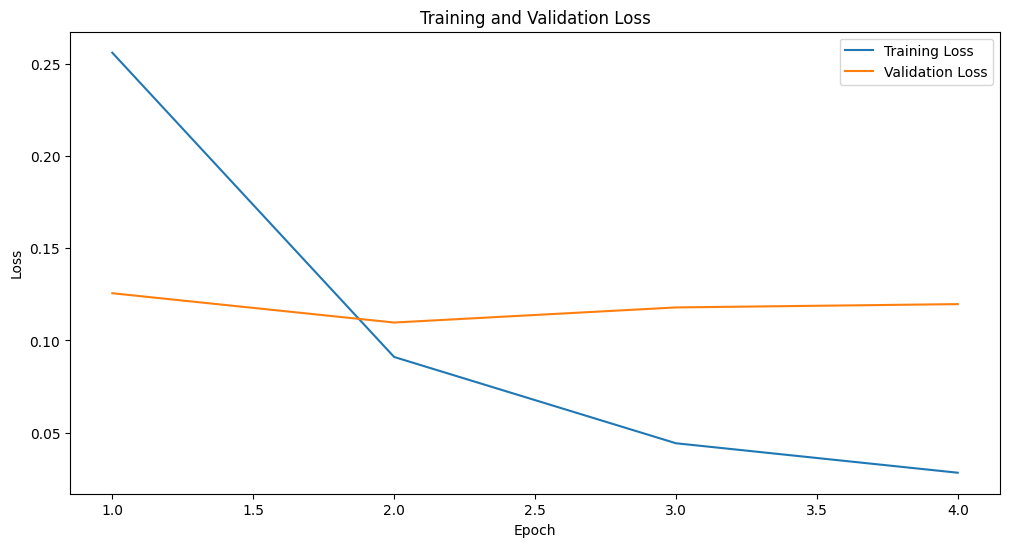

In [ ]:
# Plot the training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label="Training Loss")
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

### Evaluacija nad testnim podacima

In [ ]:
test_input_ids, test_attention_masks = encode_data(list(X_test))

test_labels = torch.tensor(y_test.values, dtype=torch.long)


test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels)


test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)


def evaluate_model(model, dataloader, device):
    model.eval()
    total_test_loss = 0
    all_preds = []
    all_labels = []

    for batch in dataloader:
        (b_input_ids, b_input_mask, b_labels) = tuple(t.to(device) for t in batch)

        b_labels = b_labels.long()

        with torch.no_grad():
            outputs = bert_model(b_input_ids, attention_mask=b_input_mask)

        logits = outputs.logits
        loss = loss_fn(logits, b_labels)

        total_test_loss += loss.item()

        # get predictions
        preds = torch.argmax(logits, dim=-1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(b_labels.cpu().numpy())

    avg_loss = total_test_loss / len(dataloader)
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    roc_auc = roc_auc_score(all_labels, all_preds)

    return avg_loss, accuracy, precision, recall, f1, roc_auc


test_loss, test_accuracy, test_precision, test_recall, test_f1, test_roc_auc = (
    evaluate_model(bert_model, test_loader, device)
)

print(f"Test loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")
print(f"Test ROC-AUC: {test_roc_auc:.4f}")

Test loss: 0.1299
Test Accuracy: 0.9616
Test Precision: 0.9625
Test Recall: 0.9625
Test F1 Score: 0.9625
Test ROC-AUC: 0.9615
